<a href="https://colab.research.google.com/github/kundajelab/adar_editing/blob/master/xgboost_with_shap/AJUBA_XGBOOST_WITH_TREESHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Uncomment these lines if running as a google colab notebook: 
#!pip install numpy==1.15
#! git clone https://github.com/kundajelab/adar_editing
#import os
#os.chdir("adar_editing/xgboost_with_shap/")
#!pip install shap
#!pip install --upgrade xgboost
#!pip install cufflinks


In [2]:
%load_ext autoreload
%autoreload 2   

In [3]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


In [5]:
#helper utilities for model training and interpretation 
import shap
from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import chart_studio.plotly as plotly
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap

import feature_subsets
import xgboost



## AJUBA xgboost with TreeShap <a name='outline'>
<ol>
    <li><a href=#1>Computational Dataset</a></li>
    <li><a href=#2>Computational Dataset Feature Subsets</a></li>
    <li><a href=#3>Exclude mut features</a></li>
 </ol>


## AJUBA Computational features <a name='1'>
<a href=#outline>Home</a>

In [6]:
data=pd.read_csv("../xin_feature_matrices/ajuba_bc_computational.features.csv",header=0,sep=',',index_col=0)

In [7]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [8]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(482, 196)
{64.0: 22, 65.0: 21, 66.0: 22, 67.0: 22, 68.0: 22, 69.0: 23, 70.0: 23, 71.0: 24, 72.0: 23, 73.0: 33, 75.0: 33, 76.0: 24, 77.0: 24, 78.0: 23, 79.0: 23, 80.0: 22, 81.0: 22, 82.0: 22, 83.0: 22, 84.0: 22, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 10}


In [9]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [10]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [11]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

u1_struct:I
mut_ref_nt:C
d2_3prm_cp_internal:C:G
u1_exist
site_3prm_cp_bulge:A:U
u3_struct:H
mut_ref_nt:A
d1_struct:S
u2_exist
site_prev_nt:A
d2_5prm_cp_bulge:A:U
d1_3prm_cp_internal
u3_5prm_cp_internal:G:C
u2_5prm_cp_bulge:U:A
d3_length_internal_ecs
site_3prm_cp_internal:C:G
site_prev_struct:I
u3_5prm_cp_hairpin:A:U
mut_nt:G
d3_exist
d1_5prm_cp_hairpin
site_3prm_cp_bulge:G:U
u3_5prm_cp_bulge:C:G
u3_3prm_cp_bulge:U:A
u1_distance
d3_5prm_cp_internal
d3_5prm_cp_bulge
u3_5prm_cp_internal:A:U
d2_3prm_cp_bulge:G:C
u3_3prm_cp_internal:U:A
u2_3prm_cp_bulge:U:G
u2_3prm_cp_internal:A:U
d2_length_hairpin
mut_prev_struct:H
u2_5prm_cp_bulge:G:C
d2_3prm_cp_bulge:U:G
d1_length_internal_ecs
d3_5prm_cp_hairpin
u2_5prm_cp_internal:C:G
d3_3prm_cp_internal
site_next_struct:S
d3_length_bulge
d1_distance
u1_length_internal_es
site_5prm_cp_bulge:A:U
site_5prm_cp_bulge:C:G
u1_length_hairpin
d1_5prm_cp_bulge
d3_length_hairpin
mut_ref_nt:U
mut_ref_nt:G
d1_5prm_cp_internal
u3_3prm_cp_bulge:C:G
u1_5prm_cp_hairpi

In [12]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [13]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [14]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(326, 113)
(326,)
(77, 113)
(77,)
(99, 113)
(99,)


In [15]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [16]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [17]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [18]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.73592	eval-mae:0.31387	eval-map:1.00000	eval-aucpr:0.17769	eval-rmse:0.32023	train-auc:0.71213	train-mae:0.32457	train-map:1.00000	train-aucpr:0.14579	train-rmse:0.32742
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.74177	eval-mae:0.22094	eval-map:1.00000	eval-aucpr:0.19265	eval-rmse:0.22575	train-auc:0.71613	train-mae:0.22814	train-map:1.00000	train-aucpr:0.15613	train-rmse:0.23064
[2]	eval-auc:0.75598	eval-mae:0.15587	eval-map:1.00000	eval-aucpr:0.21610	eval-rmse:0.15966	train-auc:0.71777	train-mae:0.16059	train-map:1.00000	train-aucpr:0.15919	train-rmse:0.16295
[3]	eval-auc:0.75967	eval-mae:0.10996	eval-map:1.00000	eval-aucpr:0.23303	eval-rmse:0.11371	train-auc:0.71812	train-mae:0.11305	train-map:1.00000	train-aucpr:0.16084	train-rmse:0.11551
[4]	eval-auc:0.77480	eval-mae:0.07926	eval-map:1.00000	eval-aucpr:0.23590	eval-rmse:0.08375	train-auc:0.76003	train

[44]	eval-auc:0.80229	eval-mae:0.01351	eval-map:1.00000	eval-aucpr:0.23039	eval-rmse:0.04084	train-auc:0.81310	train-mae:0.00142	train-map:1.00000	train-aucpr:0.18373	train-rmse:0.00210
[45]	eval-auc:0.80222	eval-mae:0.01351	eval-map:1.00000	eval-aucpr:0.23035	eval-rmse:0.04069	train-auc:0.81313	train-mae:0.00131	train-map:1.00000	train-aucpr:0.18376	train-rmse:0.00194
[46]	eval-auc:0.80231	eval-mae:0.01348	eval-map:1.00000	eval-aucpr:0.23040	eval-rmse:0.04069	train-auc:0.81314	train-mae:0.00129	train-map:1.00000	train-aucpr:0.18377	train-rmse:0.00190
[47]	eval-auc:0.80233	eval-mae:0.01345	eval-map:1.00000	eval-aucpr:0.23040	eval-rmse:0.04068	train-auc:0.81319	train-mae:0.00124	train-map:1.00000	train-aucpr:0.18378	train-rmse:0.00181
[48]	eval-auc:0.80231	eval-mae:0.01346	eval-map:1.00000	eval-aucpr:0.23037	eval-rmse:0.04068	train-auc:0.81323	train-mae:0.00118	train-map:1.00000	train-aucpr:0.18379	train-rmse:0.00173
[49]	eval-auc:0.80234	eval-mae:0.01344	eval-map:1.00000	eval-aucpr:0.2

In [19]:
# save to binary file for faster loading
bst.save_model('ajuba.computational.model')
# save model to text file 
bst.dump_model('ajuba.computational.raw.txt')


In [20]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [21]:
## Get performance metrics on full dataset 
from helpers import * 
print_aggregate_peformance_metrics(train_y,train_pred,
                                   eval_y,eval_pred,
                                   test_y,test_pred,
                                   positive_thresh=0.07)

Train
	Spearman corr : SpearmanrResult(correlation=0.9969339498313444, pvalue=0.0)
	Pearson corr : (0.9997482040416412, 0.0)
	MAE : 0.0008795823996683083
	MAPE : 0.030071036196425118
	RMSE : 0.001287116680996062
	auPRC : 1.0000000000000002
	auROC : 1.0
Eval
	Spearman corr : SpearmanrResult(correlation=0.8869095465539641, pvalue=7.206158295966419e-27)
	Pearson corr : (0.8819872665522444, 3.246097432764128e-26)
	MAE : 0.01349178489474989
	MAPE : 0.19971621332017211
	RMSE : 0.04076904675084777
	auPRC : 0.9924242424242424
	auROC : 0.9986225895316805
Test
	Spearman corr : SpearmanrResult(correlation=0.9002384600479869, pvalue=8.393876784977655e-37)
	Pearson corr : (0.8740889275840102, 3.5315007596241296e-32)
	MAE : 0.01753009634362099
	MAPE : 0.3941300940614128
	RMSE : 0.036770679884055114
	auPRC : 0.9593656343656343
	auROC : 0.998211091234347


In [22]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9969339498313444, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.8869095465539641, pvalue=7.206158295966419e-27)
Test:SpearmanrResult(correlation=0.9002384600479869, pvalue=8.393876784977655e-37)


Pearson correlation:
Train:(0.9997482040416412, 0.0)
Eval:(0.8819872665522444, 3.246097432764128e-26)
Test:(0.8740889275840102, 3.5315007596241296e-32)


In [23]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0008795823996683083
MAE Eval:0.01349178489474989
MAE Test:0.01753009634362099


In [24]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:3.007103619642512%
MAPE Eval:19.97162133201721%
MAPE Test:39.41300940614128%


In [25]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.001287116680996062
RMSE Eval:0.04076904675084777
RMSE Test:0.036770679884055114


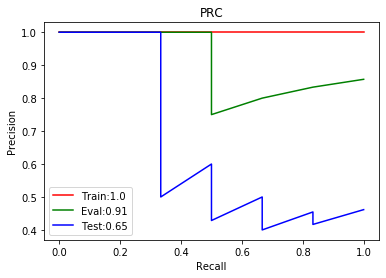

In [26]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.2 are labeled as "0". 
## Editing levels >= 0.2 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.2,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.2,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.2,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

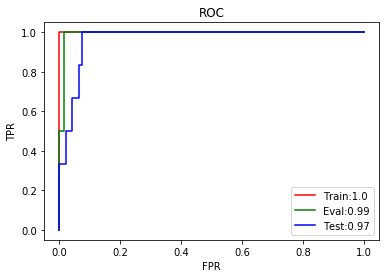

In [27]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.2,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.2,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.2,test_pred)

auroc_train=roc_auc_score(train_y>=0.2,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.2,eval_pred)
auroc_test=roc_auc_score(test_y>=0.2,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

In [28]:
#calculate R^2, which is representative of variance explained 
# https://datascienceplus.com/extreme-gradient-boosting-with-r/
# https://arxiv.org/pdf/1706.06060.pdf

residuals = test_y - test_pred

y_test_mean = np.mean(test_pred)
print(y_test_mean)
#calculate total sum of squares 
tss=sum((test_y-y_test_mean)*(test_y-y_test_mean))
print(tss)
# Calculate residual sum of squares
rss =  sum(residuals*residuals)
print(rss)
# Calculate R-squared
rsq  =  1 - (rss/tss)
print('The R-square of the test data is ', round(rsq,3), '\n')

0.051705208
0.46033503397414943
0.13385620701442988
The R-square of the test data is  0.709 



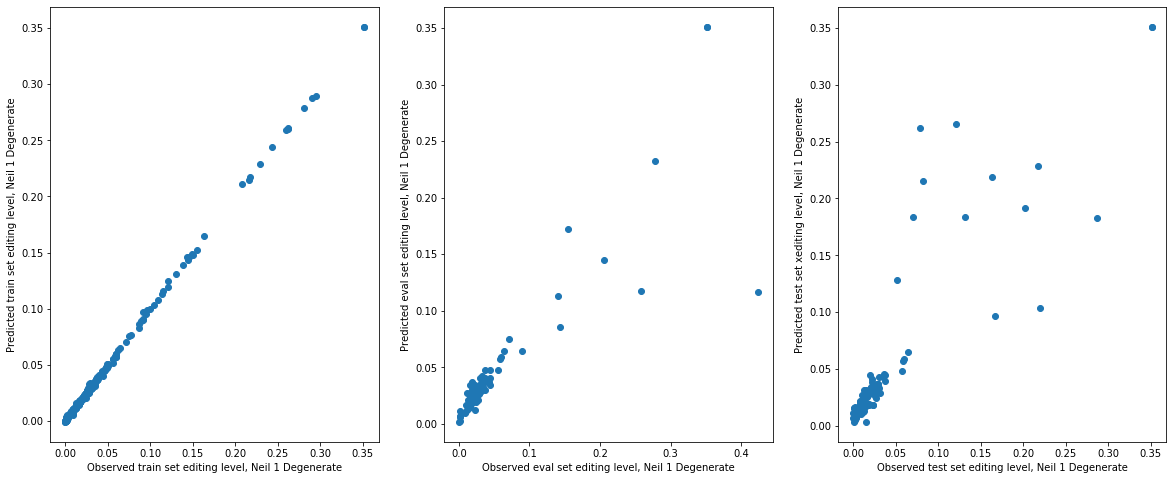

In [29]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set xediting level, Neil 1 Degenerate")

plt.show()

In [30]:
import plotnine
from plotnine import *
test_df=pd.DataFrame({'Observed':test_y,
                     'Predicted':test_pred,
                     'Dataset':'AJUBA'})

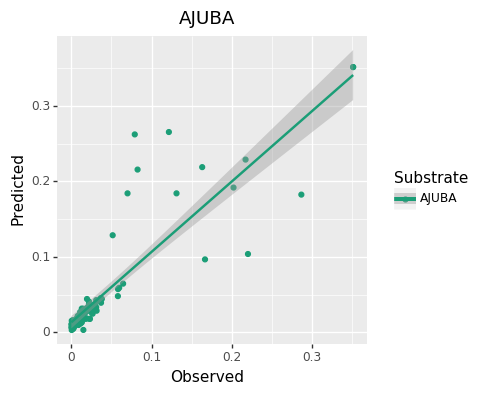

<ggplot: (8731321766365)>


In [32]:
plotnine.options.figure_size = (4, 4)

p=(ggplot(test_df, aes('Observed', 'Predicted', color='factor(Dataset)'))
 + geom_point()
 + stat_smooth(method='lm')
 + scale_color_manual(values=['#1b9e77'],name="Substrate")
 + ggtitle("AJUBA"))
print(p)
ggsave(plot=p, filename='AJUBA.comp.substrate.svg',width=4,height=4,units='in')


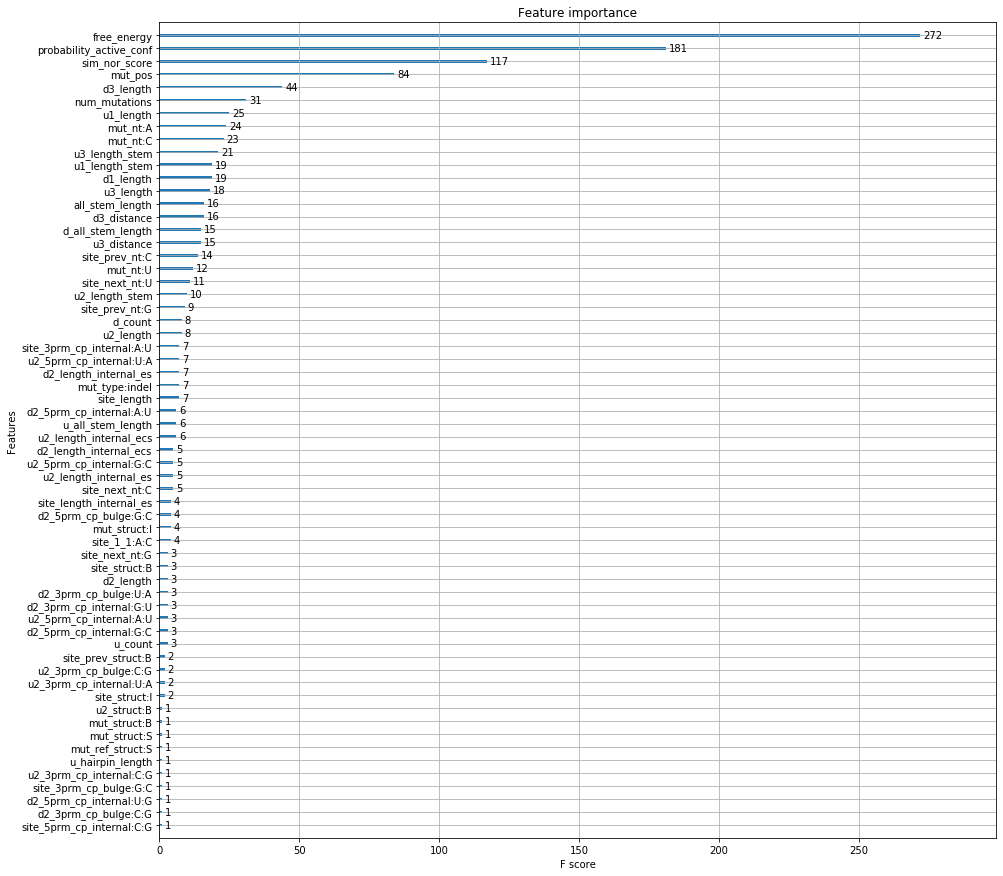

In [33]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

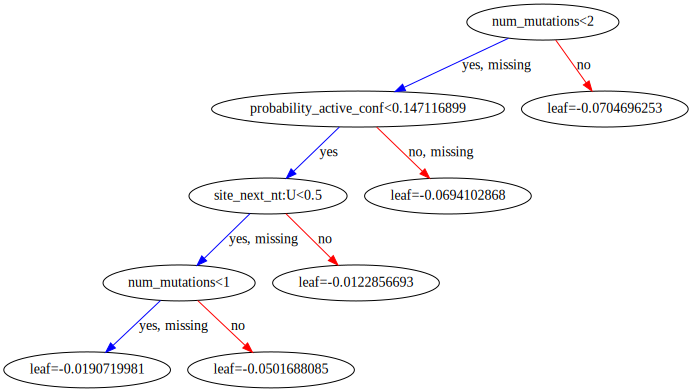

In [35]:
xgboost.to_graphviz(bst, num_trees=2)


In [34]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

(99, 113)

In [35]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

In [36]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

In [37]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

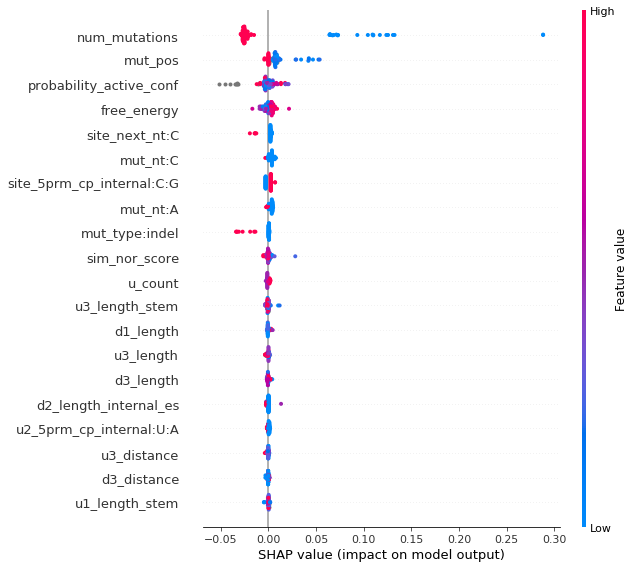

In [38]:
# summarize the effect of all the features 
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X,show=False)
plt.savefig("AJUBA.comp.shap.svg", format='svg',width=20,height=10,dpi=300,bbox_inches="tight")



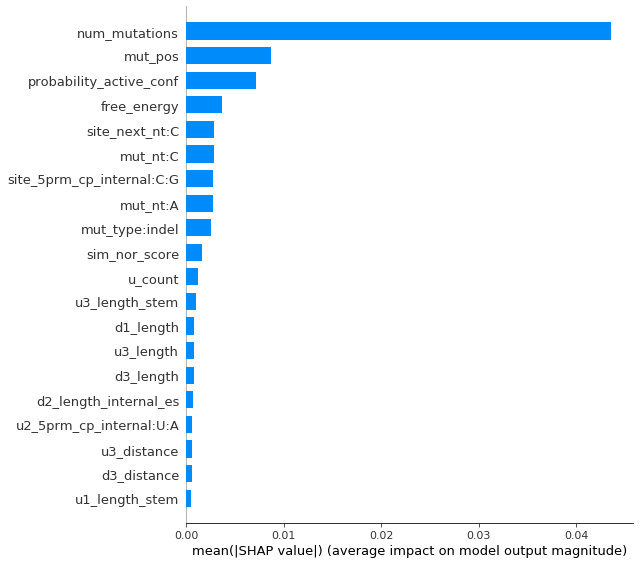

In [39]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [40]:
mean_abs_shap_vals=np.mean(abs(shap_values),axis=0)
features=test_X.columns
shap_dict=pd.DataFrame({'feature':features,
          'mean_abs_shap':mean_abs_shap_vals})
shap_dict.to_csv("AJUBA_comp_shap_mean_abs.txt",index=False,sep='\t')

In [41]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

(99, 113, 113)

In [42]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [43]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [44]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)


## Computational Dataset: Feature Subsets<a name='2'>
<a href=#outline>Home</a>

In [45]:
shap_values=pd.DataFrame(shap_values,columns=Cols)

['site_prev_nt*', 'site_next_nt*']


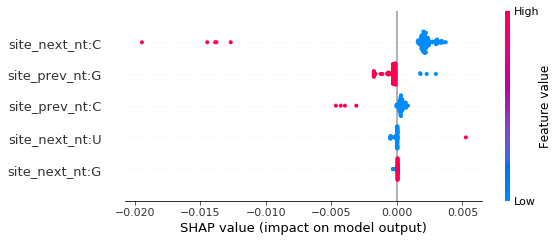

Contribution/Total:0.044051915
['free_energy*', 'sim_nor_score*', 'probability_active_conf*']


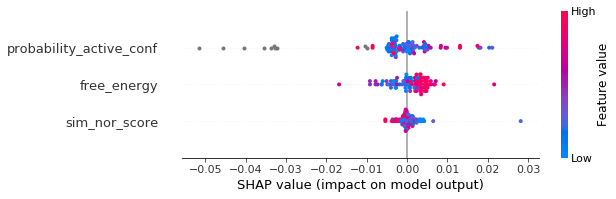

Contribution/Total:0.13481855
['u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*']


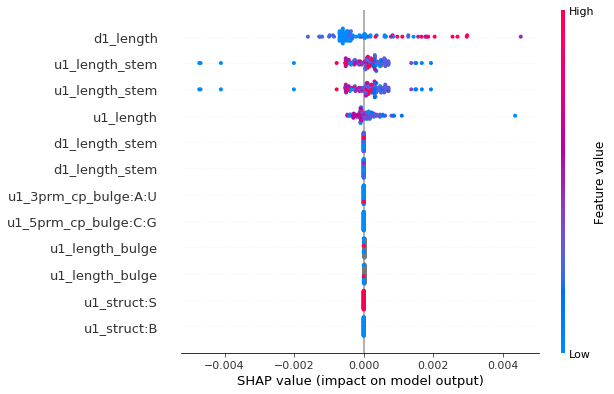

Contribution/Total:0.022595182
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*']


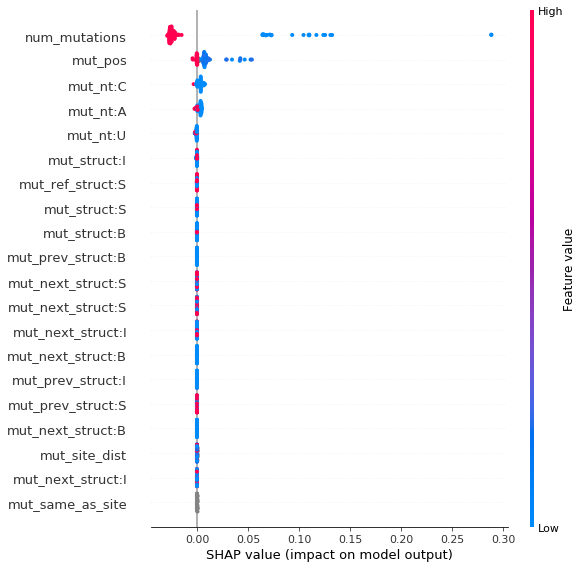

Contribution/Total:0.63116264
['site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


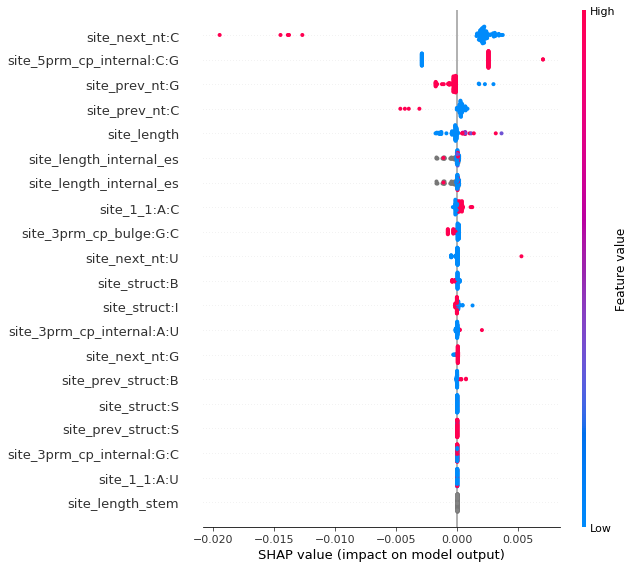

Contribution/Total:0.090721555
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*']


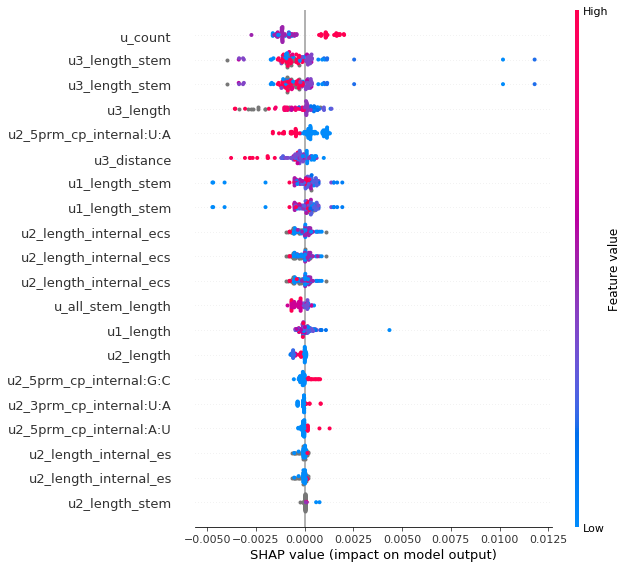

Contribution/Total:0.09304629
['d_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_struct*', 'd2_length*', 'd2_length_stem*', 'd2_length_hairpin*', 'd2_length_bulge*', 'd2_length_internal_es*', 'd2_length_internal_ecs*', 'd2_5prm_cp_hairpin*', 'd2_5prm_cp_bulge*', 'd2_3prm_cp_bulge*', 'd2_5prm_cp_internal*', 'd2_3prm_cp_internal*', 'd3_exist*', 'd3_distance*', 'd3_struct*', 'd3_length*', 'd3_length_stem*', 'd3_length_hairpin*', 'd3_length_bulge*', 'd3_length_internal_es*', 'd3_length_internal_ecs*', 'd3_5prm_cp_hairpin*', 'd3_5prm_cp_bulge*', 'd3_3prm_cp_bulge*', 'd3_5prm_cp_internal*', 'd3_3prm_cp_internal*']


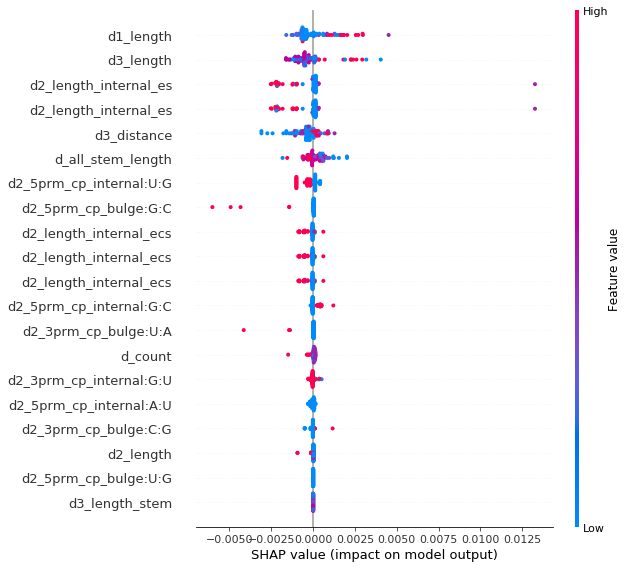

Contribution/Total:0.05772541
['u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_cp_hairpin*', 'u2_5prm_cp_bulge*', 'u2_3prm_cp_bulge*', 'u2_5prm_cp_internal*', 'u2_3prm_cp_internal*', 'u3_exist*', 'u3_distance*', 'u3_struct*', 'u3_length*', 'u3_length_stem*', 'u3_length_hairpin*', 'u3_length_bulge*', 'u3_length_internal_es*', 'u3_length_internal_ecs*', 'u3_5prm_cp_hairpin*', 'u3_5prm_cp_bulge*', 'u3_3prm_cp_bulge*', 'u3_5prm_cp_internal*', 'u3_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*',

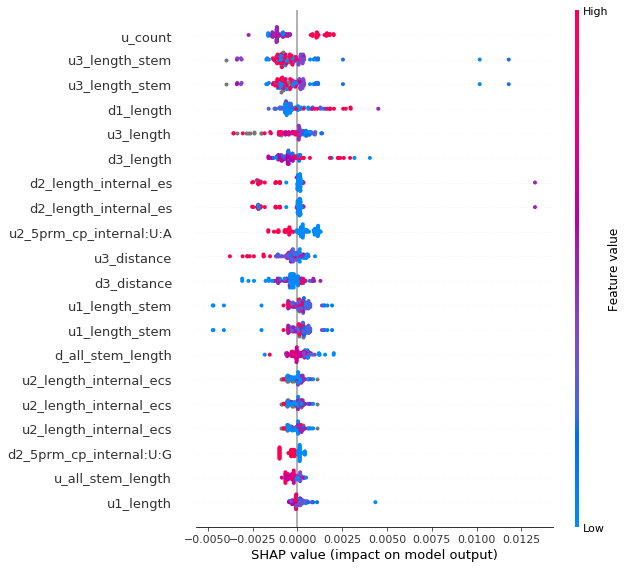

Contribution/Total:0.1507717
['num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


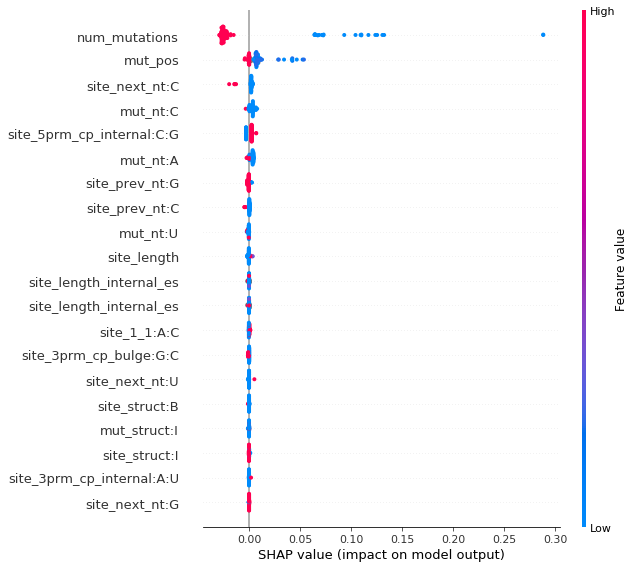

Contribution/Total:0.72188425
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'd_count*', 'd_all_stem_length*', 'd1_exist*', 'd1_distance*', 'd1_struct*', 'd1_length*', 'd1_length_stem*', 'd1_length_hairpin*', 'd1_length_bulge*', 'd1_length_internal_es*', 'd1_length_internal_ecs*', 'd1_5prm_cp_hairpin*', 'd1_5prm_cp_bulge*', 'd1_3prm_cp_bulge*', 'd1_5prm_cp_internal*', 'd1_3prm_cp_internal*', 'd2_exist*', 'd2_distance*', 'd2_

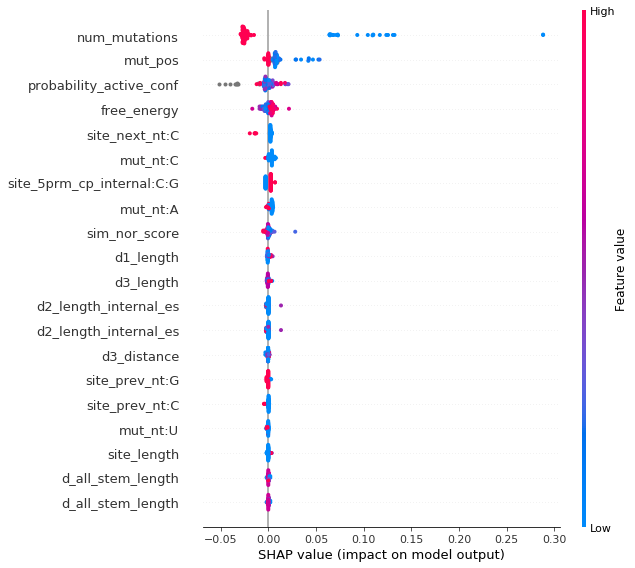

Contribution/Total:0.9252115
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'num_mutations*', 'mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'mut_struct*', 'mut_ref_struct*', 'mut_prev_struct*', 'mut_next_struct*', 'mut_same_as_site*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 

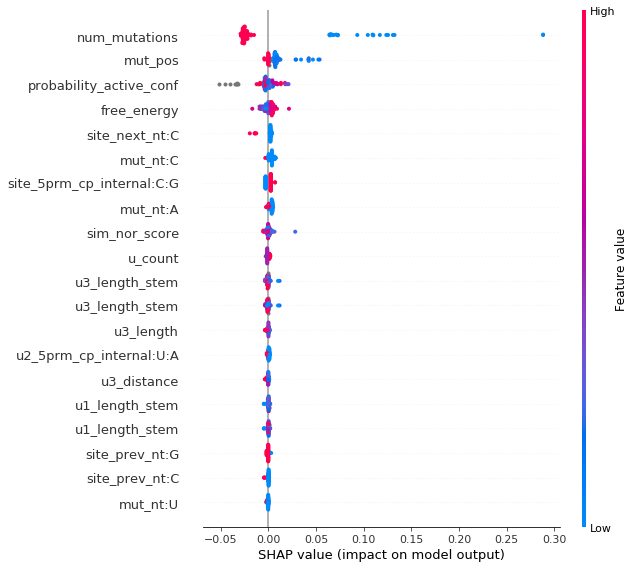

Contribution/Total:0.9605324
['site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*']


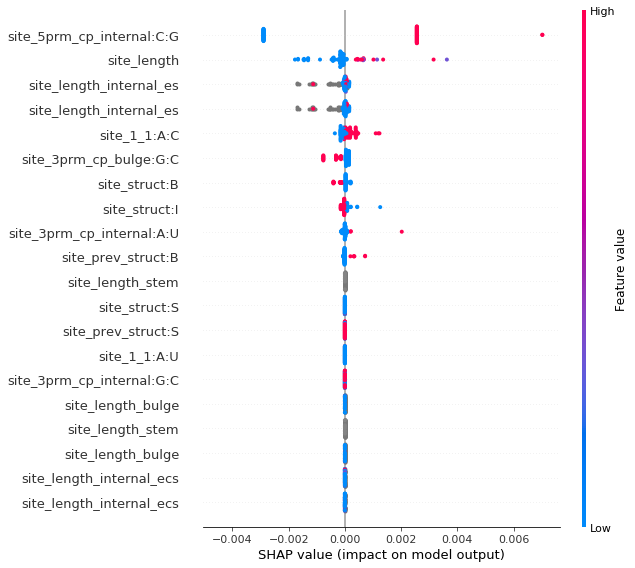

Contribution/Total:0.046669636
['site_prev_nt*', 'site_next_nt*']


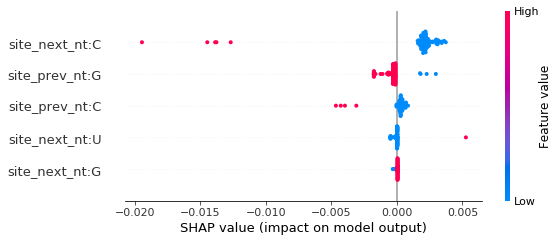

Contribution/Total:0.044051915
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*']


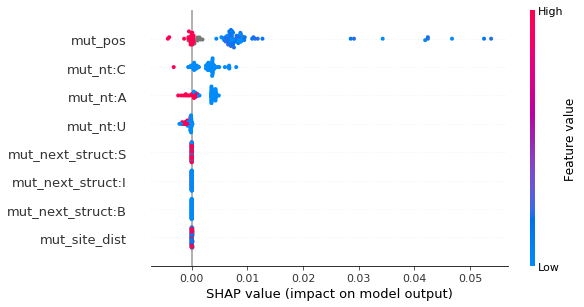

Contribution/Total:0.15889788
['mut_pos*', 'mut_site_dist*', 'mut_ref_nt*', 'mut_nt*', 'site_prev_nt*', 'site_next_nt*']


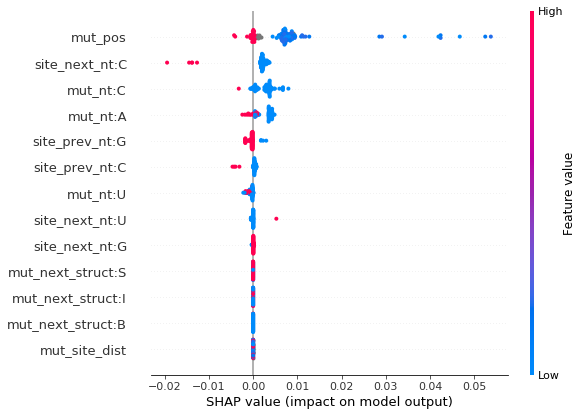

Contribution/Total:0.20294978
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*', 'site_prev_nt*', 'site_next_nt*', 'site_struct*', 'site_prev_struct*', 'site_next_struct*', 'site_1_1*', 'site_length*', 'site_length_stem*', 'site_length_hairpin*', 'site_length_bulge*', 'site_length_internal_es*', 'site_length_internal_ecs*', 'site_5prm_cp_hairpin*', 'site_5prm_cp_bulge*', 'site_3prm_cp_bulge*', 'site_5prm_cp_internal*', 'site_3prm_cp_internal*', 'u_count*', 'u_all_stem_length*', 'u_hairpin_length*', 'u1_exist*', 'u1_distance*', 'u1_struct*', 'u1_length*', 'u1_length_stem*', 'u1_length_hairpin*', 'u1_length_bulge*', 'u1_length_internal_es*', 'u1_length_internal_ecs*', 'u1_5prm_cp_hairpin*', 'u1_5prm_cp_bulge*', 'u1_3prm_cp_bulge*', 'u1_5prm_cp_internal*', 'u1_3prm_cp_internal*', 'u2_exist*', 'u2_distance*', 'u2_struct*', 'u2_length*', 'u2_length_stem*', 'u2_length_hairpin*', 'u2_length_bulge*', 'u2_length_internal_es*', 'u2_length_internal_ecs*', 'u2_5prm_c

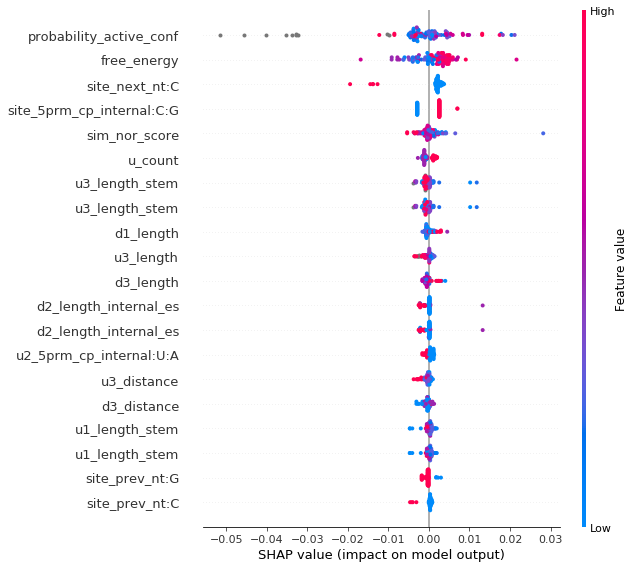

Contribution/Total:0.38709518
['all_stem_length', 'free_energy*', 'sim_nor_score*', 'probability_active_conf*']


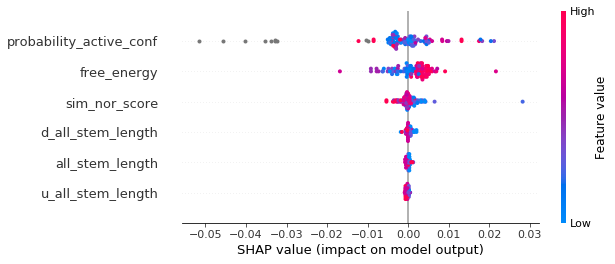

Contribution/Total:0.14560193


In [46]:
from feature_subsets import * 
subset_names=["sub_site_seq","biophysical","u1_d1","mut","site","u","d","u_d","mut_site","no_up","no_down","site_struct","site_seq","mut_seq","mut_seq_site","no_mut","overall_structure"]
subset_contribs=[]
for subset in [sub_site_seq,biophysical,u1_d1,mut,site,u,d,u_d,mut_site,no_up,no_down,site_struct,site_seq,mut_seq,mut_seq_site,no_mut,overall_structure]: 
  print(subset)
  cur_features=filter_features(shap_values,subset)
  cur_feature_shap=shap_values[cur_features].values 
  cur_feature_data_X=test_X[cur_features]
  shap.summary_plot(cur_feature_shap, cur_feature_data_X)#,sort=False,max_display=50)
  contrib=shap_contribs_subgroup(shap_values,subset)
  subset_contribs.append(contrib)
  print("Contribution/Total:"+str(contrib))

In [47]:
subset_contrib_df=pd.DataFrame({'Subset':subset_names,
                               'Contribution':[100*i for i in subset_contribs]})

In [48]:
subset_contrib_df=subset_contrib_df.sort_values(by=['Contribution'],ascending=False)
subset_contrib_df.reset_index(inplace=True, drop=True) 

In [49]:
from pandas.api.types import CategoricalDtype

In [50]:
subset_cat = CategoricalDtype(categories=list(subset_contrib_df['Subset']), ordered=True)

# Cast the existing categories into the new category. Due to a bug in pandas
# we need to do this via a string.
subset_contrib_df['Subset_Cat'] = subset_contrib_df['Subset'].astype(str).astype(subset_cat)

In [51]:
subset_contrib_df

Subset  Contribution         Subset_Cat
0             no_down     96.053243            no_down
1               no_up     92.521149              no_up
2            mut_site     72.188425           mut_site
3                 mut     63.116264                mut
4              no_mut     38.709518             no_mut
5        mut_seq_site     20.294978       mut_seq_site
6             mut_seq     15.889788            mut_seq
7                 u_d     15.077171                u_d
8   overall_structure     14.560193  overall_structure
9         biophysical     13.481855        biophysical
10                  u      9.304629                  u
11               site      9.072156               site
12                  d      5.772541                  d
13        site_struct      4.666964        site_struct
14           site_seq      4.405192           site_seq
15       sub_site_seq      4.405192       sub_site_seq
16              u1_d1      2.259518              u1_d1

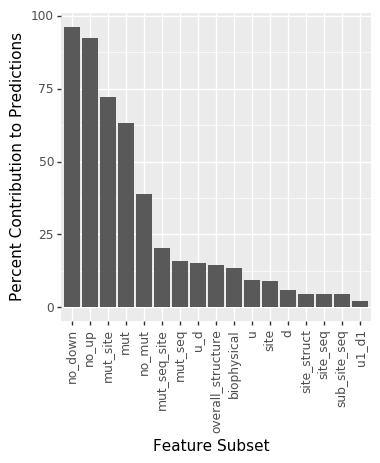

<ggplot: (8731320078537)>

In [52]:
p=(ggplot(subset_contrib_df, aes('Subset_Cat', 'Contribution'))
 + geom_bar(stat='identity')
 + xlab("Feature Subset")
 + ylab("Percent Contribution to Predictions")
 + theme(axis_text_x=element_text(angle=90))
)
ggsave(plot=p, filename='AJUBA.comp.subset.importance.svg',width=5,height=4,units='in')
p

## No "mut" features <a name='3'>
<a href=#outline>Home</a>    

In [53]:
## Read in the data 
import pandas as pd 
data=pd.read_csv("../xin_feature_matrices/ajuba_bc_computational.features.csv",header=0,sep=',',index_col=0)
#drop all mut features
cur_features=filter_features(data,feature_subsets.mut)
cur_features.remove('mut_pos')
data=data.drop(cur_features,axis=1)
data.head


<bound method NDFrame.head of               editing_value  free_energy  sim_nor_score  \
rna_id                                                    
AJUBA_BC_000       0.351000       -70.57         1.0000   
AJUBA_BC_001       0.281000       -69.67         0.9023   
AJUBA_BC_002       0.205000       -67.58         0.9911   
AJUBA_BC_003       0.099000       -67.71         1.0000   
AJUBA_BC_004       0.074500       -67.57         1.0000   
...                     ...          ...            ...   
AJUBA_BC_266       0.018715       -71.47         0.9039   
AJUBA_BC_267       0.013045       -67.48         0.9658   
AJUBA_BC_268       0.025303       -67.22         0.9163   
AJUBA_BC_269       0.058174       -67.22         0.9220   
AJUBA_BC_270       0.064515       -66.82         0.9270   

              probability_active_conf  mut_exist  mut_type  mut_pos  \
rna_id                                                                
AJUBA_BC_000                 0.142274          0        wt  

In [54]:
#remove any null editing level values 
data=data[~data["editing_value"].isnull().values]

In [55]:
data=format_for_xgboost(data)
train_split,eval_split,test_split=split_train_test_eval_by_mut_pos(data)

(482, 173)
{64.0: 22, 65.0: 21, 66.0: 22, 67.0: 22, 68.0: 22, 69.0: 23, 70.0: 23, 71.0: 24, 72.0: 23, 73.0: 33, 75.0: 33, 76.0: 24, 77.0: 24, 78.0: 23, 79.0: 23, 80.0: 22, 81.0: 22, 82.0: 22, 83.0: 22, 84.0: 22, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 0, nan: 10}


In [56]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [57]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [58]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
to_drop.append("mut_pos")
print("\n".join(to_drop))

u1_struct:I
u1_exist
site_3prm_cp_bulge:A:U
u3_struct:H
d1_struct:S
u2_exist
site_prev_nt:A
site_5prm_cp_internal:G:C
d2_5prm_cp_bulge:A:U
d1_3prm_cp_internal
u3_5prm_cp_internal:G:C
u2_5prm_cp_bulge:U:A
d3_length_internal_ecs
site_3prm_cp_internal:C:G
site_prev_struct:I
d2_5prm_cp_bulge:G:C
u3_5prm_cp_hairpin:A:U
d3_exist
d1_5prm_cp_hairpin
site_3prm_cp_bulge:G:U
u3_5prm_cp_bulge:C:G
u3_3prm_cp_bulge:U:A
u1_distance
d3_5prm_cp_internal
d3_5prm_cp_bulge
u3_5prm_cp_internal:A:U
d2_3prm_cp_bulge:G:C
u3_3prm_cp_internal:U:A
u2_3prm_cp_bulge:U:G
u2_3prm_cp_internal:A:U
d2_length_hairpin
u2_5prm_cp_bulge:G:C
d2_3prm_cp_bulge:U:G
d1_length_internal_ecs
d3_5prm_cp_hairpin
u2_5prm_cp_internal:C:G
d3_3prm_cp_internal
site_next_struct:S
d3_length_bulge
d1_distance
u1_length_internal_es
site_5prm_cp_bulge:A:U
site_5prm_cp_bulge:C:G
u1_length_hairpin
d1_5prm_cp_bulge
d3_length_hairpin
d1_5prm_cp_internal
u3_3prm_cp_bulge:C:G
u1_5prm_cp_hairpin
d3_length_internal_es
d2_exist
d2_3prm_cp_bulge:G:U
d1

In [59]:
train_split=train_split.drop(to_drop,axis=1)
eval_split=eval_split.drop(to_drop,axis=1)
test_split=test_split.drop(to_drop,axis=1)

In [60]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)

eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)

test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [61]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)


(316, 94)
(316,)
(88, 94)
(88,)
(98, 94)
(98,)


In [62]:
## format matrixes for xgboost 
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [63]:
## set model training parameters 
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 
param['eval_metric'] = ['auc','mae','map','aucpr','rmse']

In [64]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [65]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[0]	eval-auc:0.59428	eval-mae:0.32463	eval-map:1.00000	eval-aucpr:0.11930	eval-rmse:0.33026	train-auc:0.52702	train-mae:0.32387	train-map:1.00000	train-aucpr:0.06403	train-rmse:0.32814
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[1]	eval-auc:0.67636	eval-mae:0.22963	eval-map:1.00000	eval-aucpr:0.15741	eval-rmse:0.23571	train-auc:0.58315	train-mae:0.22756	train-map:1.00000	train-aucpr:0.09324	train-rmse:0.23251
[2]	eval-auc:0.72559	eval-mae:0.16412	eval-map:1.00000	eval-aucpr:0.16422	eval-rmse:0.16800	train-auc:0.68097	train-mae:0.16112	train-map:1.00000	train-aucpr:0.13962	train-rmse:0.16498
[3]	eval-auc:0.76726	eval-mae:0.11842	eval-map:1.00000	eval-aucpr:0.18457	eval-rmse:0.12164	train-auc:0.68766	train-mae:0.11479	train-map:1.00000	train-aucpr:0.14600	train-rmse:0.11806
[4]	eval-auc:0.79530	eval-mae:0.08814	eval-map:1.00000	eval-aucpr:0.18755	eval-rmse:0.09059	train-auc:0.73251	train

[44]	eval-auc:0.82841	eval-mae:0.01417	eval-map:1.00000	eval-aucpr:0.20311	eval-rmse:0.03646	train-auc:0.81089	train-mae:0.00182	train-map:1.00000	train-aucpr:0.18170	train-rmse:0.00317
[45]	eval-auc:0.82815	eval-mae:0.01416	eval-map:1.00000	eval-aucpr:0.20294	eval-rmse:0.03647	train-auc:0.81091	train-mae:0.00174	train-map:1.00000	train-aucpr:0.18170	train-rmse:0.00308
[46]	eval-auc:0.82818	eval-mae:0.01415	eval-map:1.00000	eval-aucpr:0.20295	eval-rmse:0.03648	train-auc:0.81093	train-mae:0.00167	train-map:1.00000	train-aucpr:0.18171	train-rmse:0.00283
[47]	eval-auc:0.82816	eval-mae:0.01404	eval-map:1.00000	eval-aucpr:0.20294	eval-rmse:0.03648	train-auc:0.81100	train-mae:0.00157	train-map:1.00000	train-aucpr:0.18173	train-rmse:0.00273
[48]	eval-auc:0.82812	eval-mae:0.01410	eval-map:1.00000	eval-aucpr:0.20293	eval-rmse:0.03667	train-auc:0.81102	train-mae:0.00153	train-map:1.00000	train-aucpr:0.18177	train-rmse:0.00258
[49]	eval-auc:0.82848	eval-mae:0.01404	eval-map:1.00000	eval-aucpr:0.2

In [66]:
# save to binary file for faster loading
bst.save_model('neil1.computational.model')
# save model to text file 
bst.dump_model('neil1.computational.raw.txt')


In [67]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [68]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.997780150604282, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.8756568010013631, pvalue=6.367200376526235e-29)
Test:SpearmanrResult(correlation=0.8378498290674503, pvalue=5.591937414030905e-27)


Pearson correlation:
Train:(0.9996096971347394, 0.0)
Eval:(0.8555061068958286, 2.6111163323789217e-26)
Test:(0.8356240959998559, 1.0176985903038468e-26)


In [69]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0009693140830047024
MAE Eval:0.013723621599727816
MAE Test:0.0164664461443279


In [70]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:2.7072191020955785%
MAPE Eval:22.720758729068518%
MAPE Test:24.504640789672578%


In [71]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.001655830410058742
RMSE Eval:0.03675319408721212
RMSE Test:0.04276691111533063


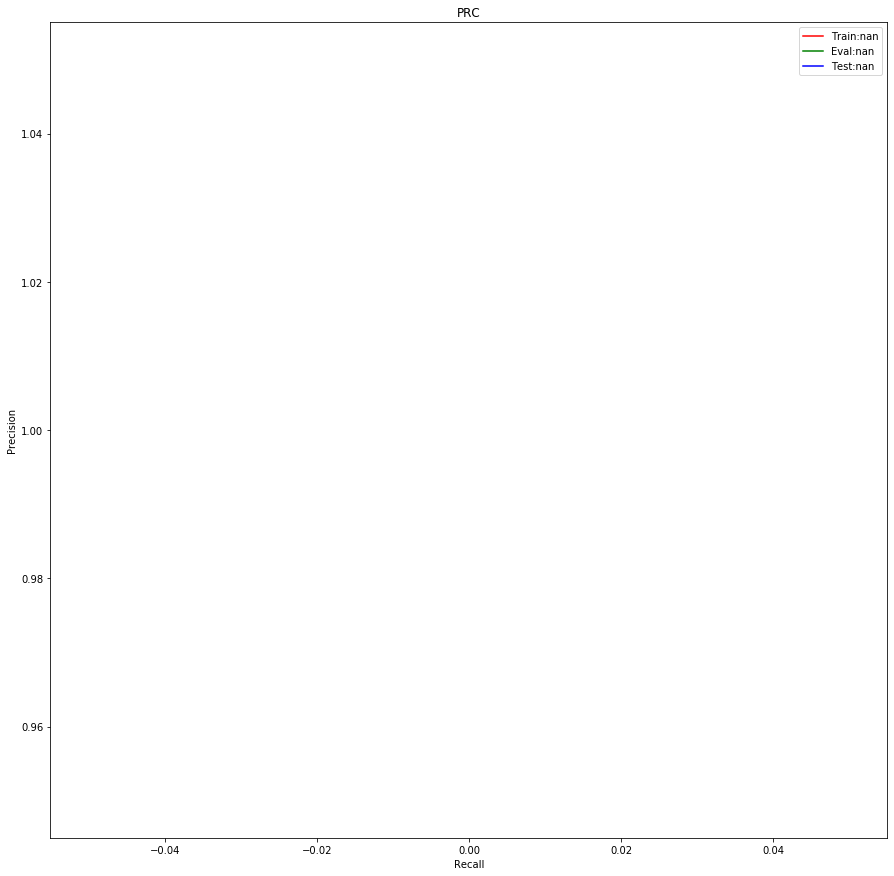

In [72]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.5,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.5,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.5,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

In [73]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.5,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.5,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.5,test_pred)

auroc_train=roc_auc_score(train_y>=0.5,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.5,eval_pred)
auroc_test=roc_auc_score(test_y>=0.5,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted train set editing level, Neil 1 Degenerate")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted eval set editing level, Neil 1 Degenerate")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, Neil 1 Degenerate")
plt.ylabel("Predicted test set editing level, Neil 1 Degenerate")

plt.show()

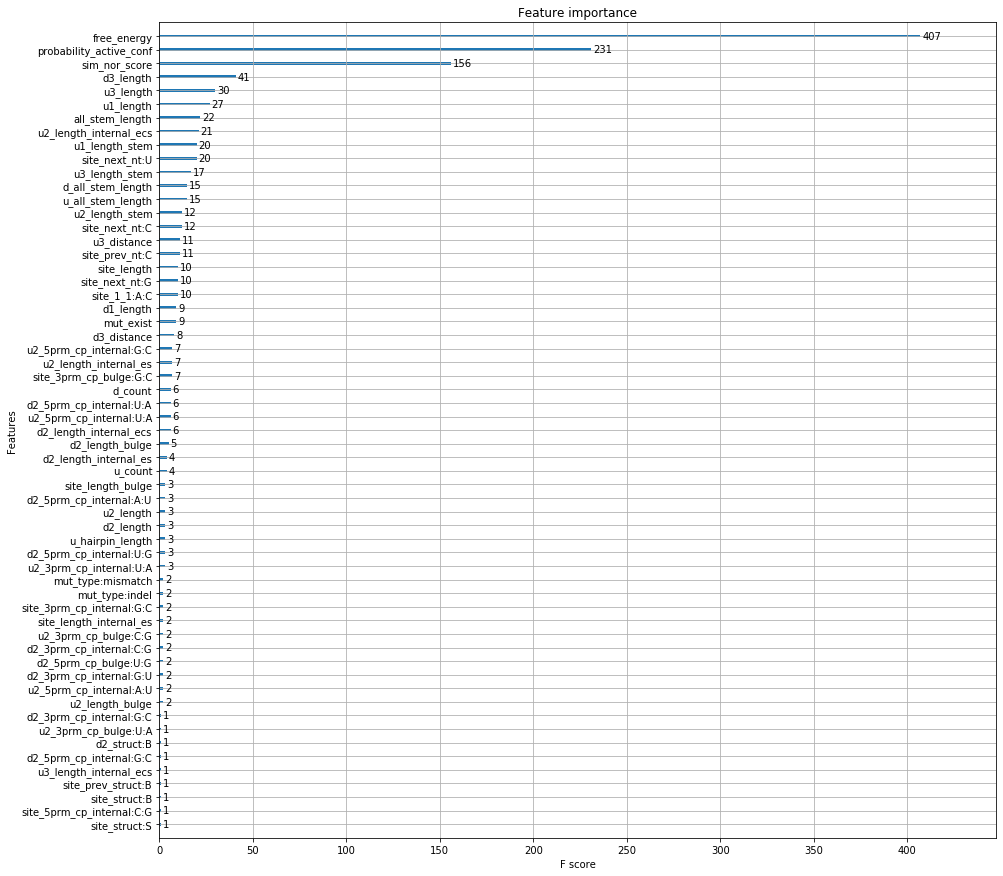

In [74]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
xgboost.plot_importance(bst)

In [75]:
xgboost.to_graphviz(bst, num_trees=2)


ImportError: You must install graphviz to plot tree

In [ ]:
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_X)
shap_values.shape

In [76]:
test_y=pd.DataFrame(test_y)
max_index=test_y.index[test_y['editing_value'] == max(test_y['editing_value'])]
max_row=test_y.index.get_loc(max_index[0])
# visualize prediction for isoform with the highest editing level 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[max_row,:], test_X.iloc[max_row,:])

TypeError: '(12, slice(None, None, None))' is an invalid key

In [77]:
# visualize prediction for isoform with the lowest editing level 
shap.initjs()
min_index=test_y.index[test_y['editing_value'] == min(test_y['editing_value'])]
min_row=test_y.index.get_loc(min_index[0])
shap.force_plot(explainer.expected_value, shap_values[min_row,:], test_X.iloc[min_row,:])

TypeError: '(69, slice(None, None, None))' is an invalid key

In [78]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values,train_X)

AssertionError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
# summarize the effect of all the features 
shap.summary_plot(shap_values, test_X)


In [ ]:
# We can also just take the mean absolute value of the SHAP values for each feature 
# to get a standard bar plot (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, test_X, plot_type="bar")

In [ ]:
## Compute pairwise interaction values from TreeShap
shap_interaction_values=explainer.shap_interaction_values(test_X)
shap_interaction_values.shape

In [ ]:
##Average interaction values across the datapoints in the test set 
mean_interaction_values=np.mean(shap_interaction_values,axis=0)

In [ ]:
Index=test_X.columns
Cols=test_X.columns
mean_interaction_values_df = pd.DataFrame(mean_interaction_values, index=Index, columns=Cols)

In [ ]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
configure_plotly_browser_state()

trace = Heatmap(z=mean_interaction_values_df.values,
                   x=Cols,
                   y=Index)
iplot([trace],show_link=False)
